# Time series forecasting with arima and sarima

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# The data

### Australia monthly beer production

### Choose data

In [2]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop('Month',1)
df = df[df.Date > '1959-12-01']
df = df[df.Date < '1973-01-01']
df.set_index('Date', inplace=True)
df

,Monthly beer production
Date,
1960-01-01,97.1
1960-02-01,93.0
1960-03-01,96.0
1960-04-01,80.5
1960-05-01,76.1
...,...
1972-08-01,127.8
1972-09-01,143.6
1972-10-01,157.6


### in a graph

<function matplotlib.pyplot.show(*args, **kw)>

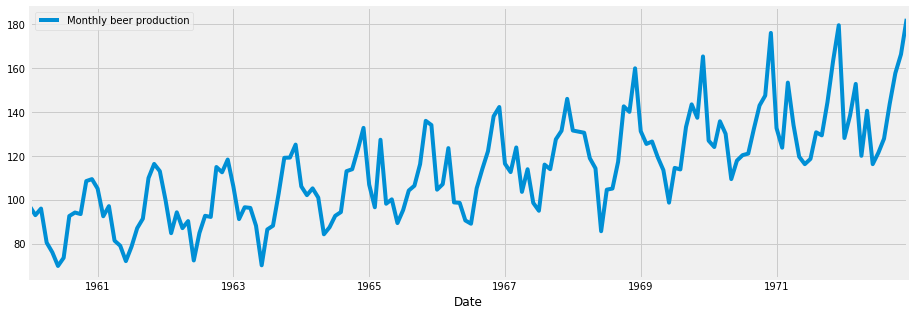

In [3]:
df.plot(figsize=(14,5))
plt.show

### Decompose the data

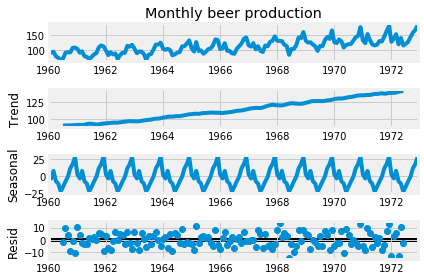

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Monthly beer production'], freq=12)
decomposition.plot()
plt.show()

### Observe the correlation

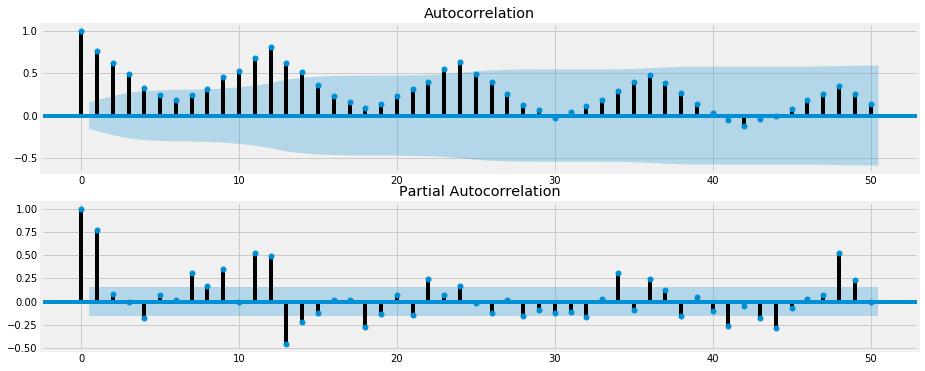

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

### Determine rolling statistics

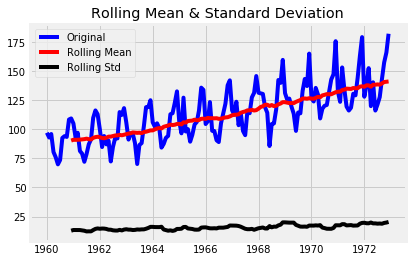

In [6]:

#Determing rolling statistics
rolmean = pd.Series(df['Monthly beer production']).rolling(window=12).mean()
rolstd = pd.Series(df['Monthly beer production']).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df['Monthly beer production'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Dickey fuller test and standardize data

In [7]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Monthly beer production'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.855123
p-value                          0.992476
#Lags Used                      11.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [8]:
df_diff = df.diff().diff(12)
df_diff.dropna(inplace=True)
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff['Monthly beer production'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -4.669501
p-value                          0.000096
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Transformed data

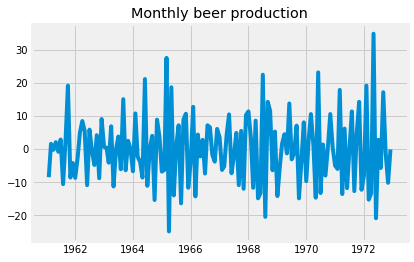

In [9]:
plt.plot(df_diff['Monthly beer production'])
plt.title('Monthly beer production')
plt.savefig('diffplot')
plt.show()

### Observe the correlation

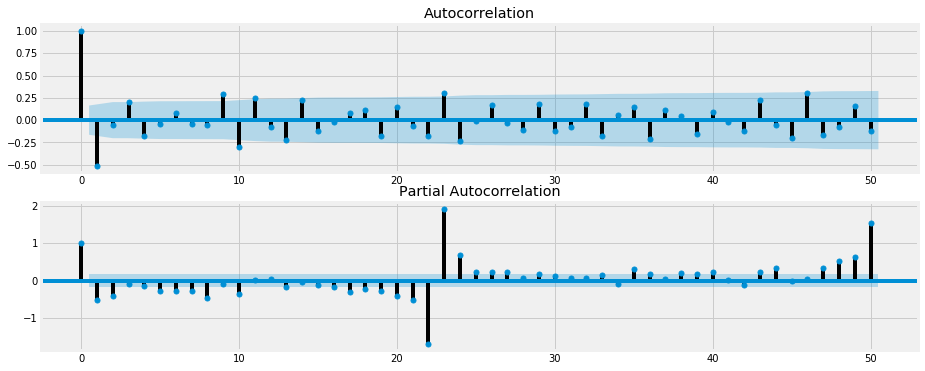

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

### Arima model

In [25]:
#pip install pmdarima
import pmdarima as pm
model = pm.auto_arima(df['Monthly beer production'],d=1, D=3,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,3,1)[12]             : AIC=1041.898, Time=1.75 sec
 ARIMA(0,1,0)(0,3,0)[12]             : AIC=1086.510, Time=0.20 sec
 ARIMA(1,1,0)(1,3,0)[12]             : AIC=1006.529, Time=1.29 sec
 ARIMA(0,1,1)(0,3,1)[12]             : AIC=inf, Time=2.95 sec
 ARIMA(1,1,0)(0,3,0)[12]             : AIC=1046.710, Time=0.42 sec
 ARIMA(1,1,0)(2,3,0)[12]             : AIC=1008.373, Time=2.90 sec
 ARIMA(1,1,0)(1,3,1)[12]             : AIC=1007.986, Time=1.85 sec
 ARIMA(1,1,0)(0,3,1)[12]             : AIC=inf, Time=2.63 sec
 ARIMA(1,1,0)(2,3,1)[12]             : AIC=1009.293, Time=6.74 sec
 ARIMA(0,1,0)(1,3,0)[12]             : AIC=1043.987, Time=0.73 sec
 ARIMA(2,1,0)(1,3,0)[12]             : AIC=979.906, Time=1.96 sec
 ARIMA(2,1,0)(0,3,0)[12]             : AIC=1037.032, Time=0.77 sec
 ARIMA(2,1,0)(2,3,0)[12]             : AIC=979.401, Time=3.55 sec
 ARIMA(2,1,0)(2,3,1)[12]             : AIC=inf, Time=7.89 sec
 ARIMA(2,1,0)(1,3,1)[12]            

In [26]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(2, 1, 0)x(2, 3, 0, 12)   Log Likelihood                -483.701
Date:                            Sun, 16 Aug 2020   AIC                            979.401
Time:                                    21:58:44   BIC                            996.076
Sample:                                         0   HQIC                           986.172
                                            - 156                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0902      0.832     -0.108      0.914      -1.721       1.540
ar.L1         -0.8263      0.083   

### Train data

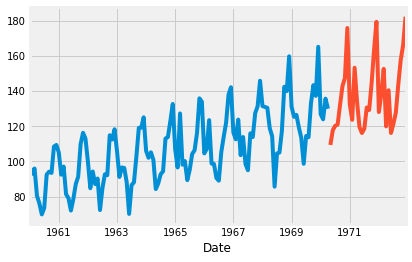

In [27]:
#divide into train and validation set
train = df[:int(0.80*(len(df)))]
test = df[int(0.80*(len(df))):]

#plotting the data
train['Monthly beer production'].plot()
test['Monthly beer production'].plot()

### Sarima model & training

In [28]:
import statsmodels.api as sm
model = SARIMAX(train['Monthly beer production'],order=(2,1,3),seasonal_order=(1,1,1,12),enforce_invertibility=False)
results = model.fit()
results.summary()

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Monthly beer production   No. Observations:                  124
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -353.279
Date:                              Sun, 16 Aug 2020   AIC                            722.559
Time:                                      21:58:53   BIC                            744.235
Sample:                                  01-01-1960   HQIC                           731.352
                                       - 04-01-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1407      0.021    -55.414      0.000      -1.181      -1.100
ar.L2         -0.9982      0.014    -70.939      0.000      -1.026      -0.971
ma.L1          0.1617      0.241      0.671      0.502      -0.310       0.634
ma.L2         -0.0687      0.230     -0.299      0.765      -0.520       0.382
ma.L3         -0.9468      0.430     -2.199      0.028      -1.790      -0.103
ar.S.L12       0.1405      0.232      0.605      0.545      -0.314       0.595
ma.S.L12      -0.7042      0.176     -3.992      0.000      -1.050      -0.358
sigma2        30.3648     13.019      2.332      0.020       4.849      55.881
===================================================================================
Ljung-Box (Q):                       57.74   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.03   Prob(JB):                         0.75
Heteroskedasticity (H):               1.67   Skew:                             0.16
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model validation

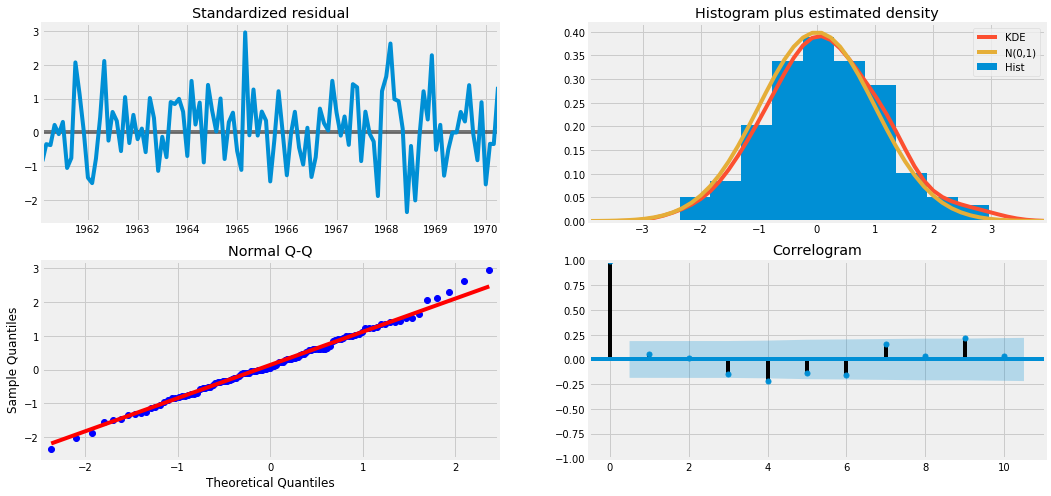

In [29]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

### Forecast vs real data

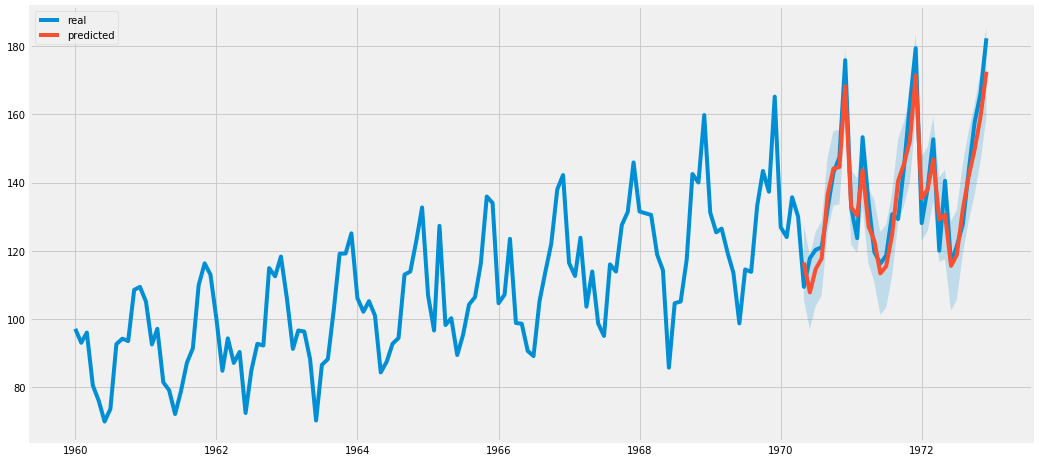

In [30]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df.index, df, label='real')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

### Compare predictions against real data

In [31]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(0,1,1,12) Predictions')
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Monthly beer production'][i]}")

predicted=116.5407874, expected=109.4
predicted=107.7615479, expected=117.8
predicted=114.6223461, expected=120.3
predicted=117.7270695, expected=121.0
predicted=136.4858334, expected=132.3
predicted=144.1107541, expected=142.9
predicted=144.5286189, expected=147.4
predicted=168.2444961, expected=175.9
predicted=132.7132247, expected=132.6
predicted=130.322862 , expected=123.7
predicted=143.6546633, expected=153.3
predicted=127.1050309, expected=134.0
predicted=122.8815377, expected=119.6
predicted=113.3487325, expected=116.2
predicted=115.4253091, expected=118.6
predicted=124.6859936, expected=130.7
predicted=140.4781604, expected=129.3
predicted=145.4134064, expected=144.4
predicted=152.271715 , expected=163.2
predicted=171.4071224, expected=179.4
predicted=135.3046123, expected=128.1
predicted=138.0665884, expected=138.4
predicted=146.7902564, expected=152.7
predicted=129.1631686, expected=120.0
predicted=130.5561172, expected=140.5
predicted=115.5447232, expected=116.2
predicted=11

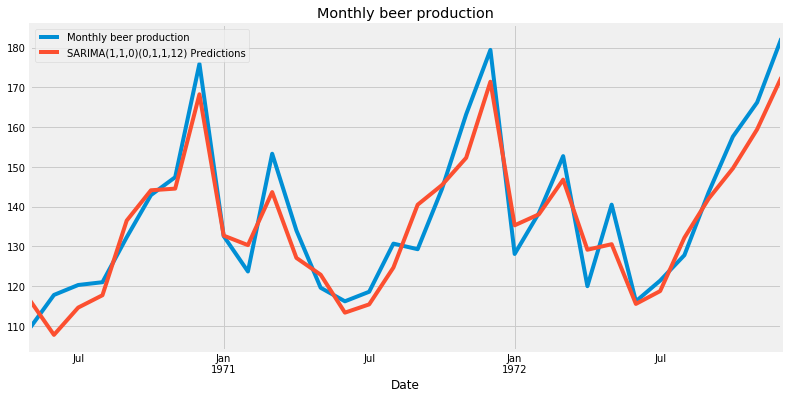

In [32]:

# Plot predictions against known values
title = 'Monthly beer production'
ax = test['Monthly beer production'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

### Test accuracy

In [33]:
r2_score(test['Monthly beer production'], predictions)*100

89.05210836108154

In [34]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Monthly beer production'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Monthly beer production'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Monthly beer production'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Monthly beer production'])/np.abs(test['Monthly beer production']))*100 

evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.890521,5.566534,41.986379,4.027151


### Forecast

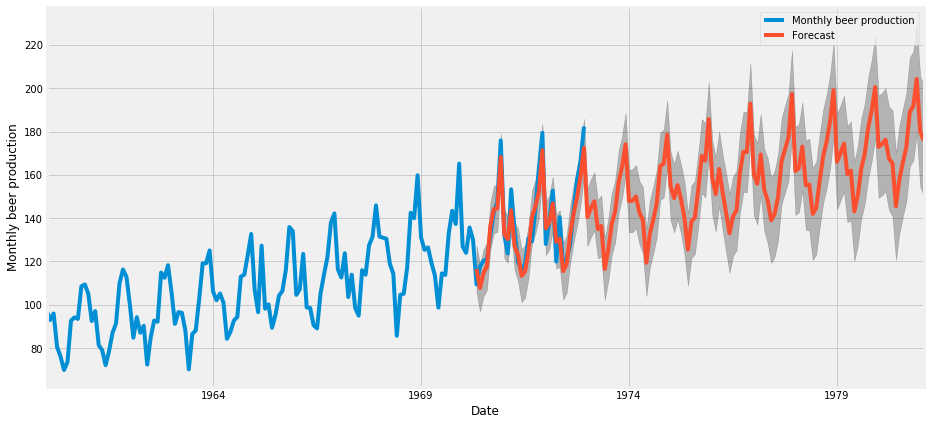

In [35]:
pred_f = results.get_forecast(steps=130)
pred_ci = pred_f.conf_int()
ax = df.plot(label='Monthly beer production', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly beer production')
plt.legend()
plt.show()

In [22]:
#df = pd.read_csv('monthly-beer-production-in-austr.csv')
#df['Date'] = pd.to_datetime(df['Month'])
#df = df.drop('Month',1)
#df = df[df.Date > '1959-12-01']
#df = df[df.Date < '1985-01-01']
#df.set_index('Date', inplace=True)